<a href="https://colab.research.google.com/github/deadsweetpotato/hoyalytics-final-model/blob/main/final_NLP_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure that NLTK resources are downloaded (only need to do this once)
nltk.download('punkt')
nltk.download('stopwords')

def load_data(file_path):
    return pd.read_csv(file_path)

def preprocess_text(text):
    # Convert to lower case
    text = text.lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

def extract_keywords(data):
    all_tokens = []
    data['Description'].dropna().apply(lambda x: all_tokens.extend(preprocess_text(x)))
    # Count frequency of each token
    token_counter = Counter(all_tokens)
    # Return most common tokens
    return token_counter.most_common()

def main():
    file_path = '/content/final_prepped_data.csv'  # Update path as needed
    data = load_data(file_path)
    keywords = extract_keywords(data)
    # print(keywords[:50])  # Print top 50 keywords
    print(keywords)  # Print top 50 keywords

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc0 in position 10: invalid start byte

## (1) 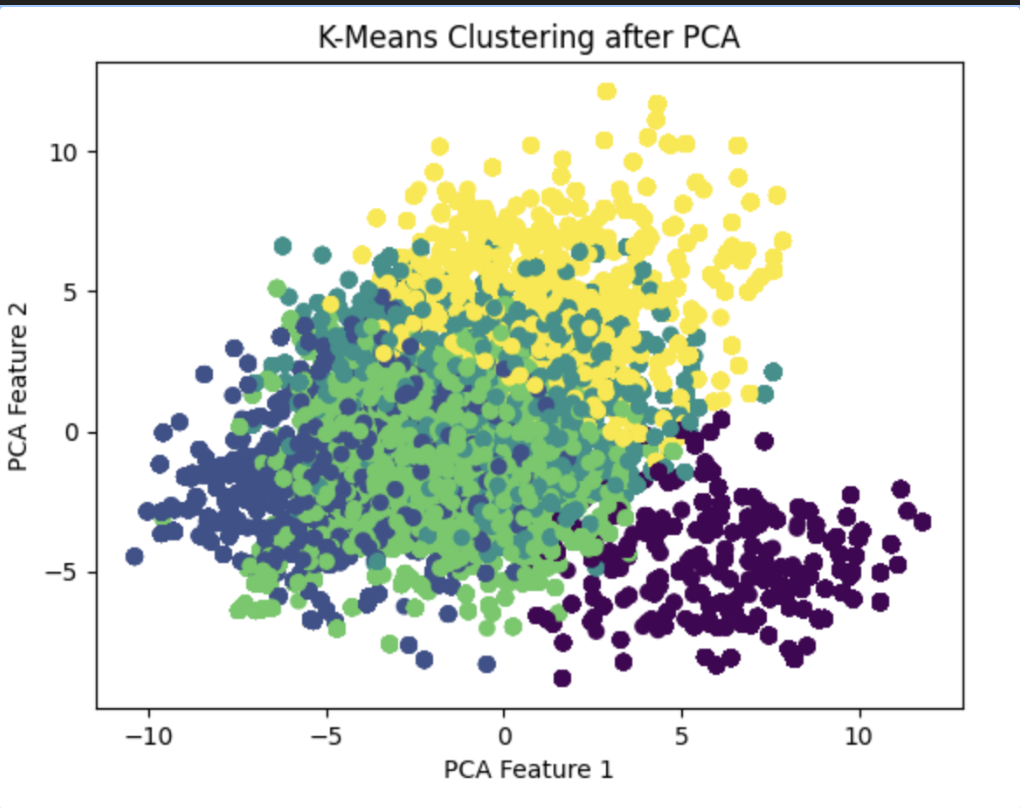K-Means Clustering w/SBERT Word Embeddings

In [ ]:
!pip install sentence-transformers

- mount the w2v300 model and load into colab

- look into gpt embeddings, bert embeddings – try to find embeddings that use phrases instead of just single words
  - langchain embeddings models (hugging face?)

- run embeddings on data to get vectors, run PCA on vectors to reduce dim-ality, use k-means cluster labels as product categories
  -

In [ ]:
# PRE-PROCESSING

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import zscore

# preprocessing
# df = pd.read_csv('/content/sample_data.csv')
# df = pd.read_csv('/content/final_prepped_data.csv')
df = pd.read_csv('/content/sample_data_100.csv')
data = df['Description']
descriptions = []
for i in data:
  i = i.lower()
  descriptions.append(i)
# print(descriptions)

descriptions_to_df = {'Descriptions': descriptions}
df = pd.DataFrame(descriptions_to_df)

In [ ]:
# S-BERT EMBEDDINGS

from sentence_transformers import SentenceTransformer

# Load a pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
embeddings = model.encode(descriptions)
print("Embedding shape:", embeddings.shape)
# print("Embedding for the first description:", embeddings[0])

# # Standardize embeddings
# scaler = StandardScaler()
# embeddings_normalized = scaler.fit_transform(embeddings)
# print("Embeddings have been standardized")

Embedding shape: (99, 384)


In [ ]:
# PCA DIM REDUCTION

from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # Keep 95% of variance
reduced_embeddings = pca.fit_transform(embeddings_normalized)


In [ ]:
print(reduced_embeddings.shape)

(99, 63)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

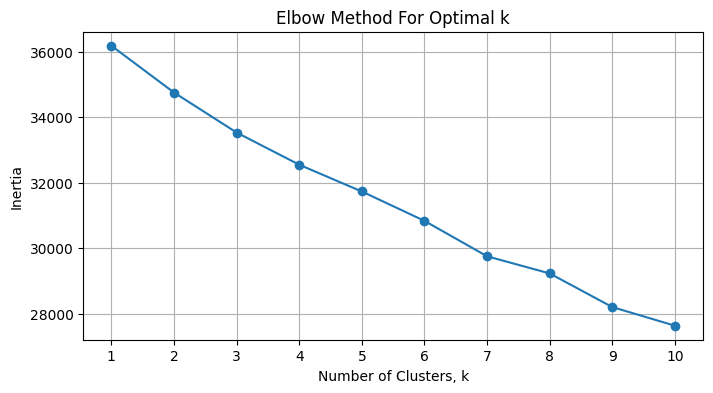

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

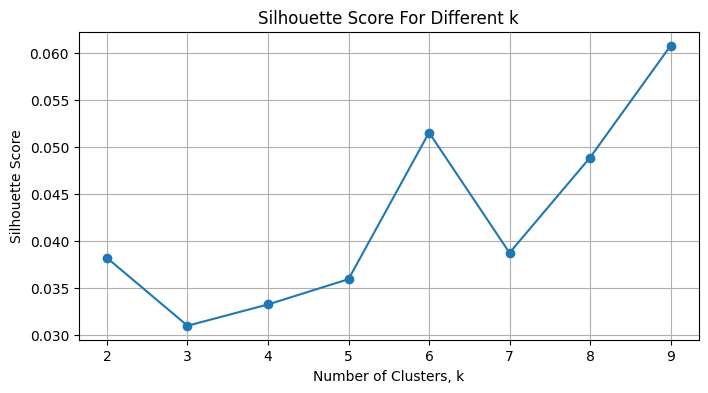

In [ ]:
# DETERMINE K – elbow method

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Running K-means with different k
inertia = []
k_range = range(1, 11)  # Change the upper limit of range based on your needs
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(reduced_embeddings)
    inertia.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Silhoutte analysis
max_k = min(10, len(reduced_embeddings) - 1)
range_n_clusters = list(range(2, max_k))  # Start at 2 because silhouette score needs at least 2 clusters to be meaningful
silhouette_avg = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_embeddings)
    silhouette_avg.append(silhouette_score(reduced_embeddings, cluster_labels))

# Plotting silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.title('Silhouette Score For Different k')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


In [ ]:
# K-MEANS CLUSTERING

k = 9  # based on silhouette scores
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings)

# Output the cluster labels
print("Cluster labels:", clusters)

# # print descriptions and their corresponding cluster
# for description, cluster in zip(descriptions, clusters):
#     print(f"{description} -> Cluster {cluster}")

Cluster labels: [6 1 6 3 4 4 7 4 1 2 4 6 2 2 0 0 4 1 4 5 3 3 7 4 4 5 8 8 5 4 3 6 4 7 4 8 7
 3 0 1 6 3 1 8 2 4 2 4 6 7 1 4 8 4 8 4 4 0 5 0 3 1 4 3 5 3 0 6 6 2 5 7 3 7
 8 7 3 5 4 3 4 4 4 3 3 4 8 3 5 6 6 3 1 7 3 4 0 4 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


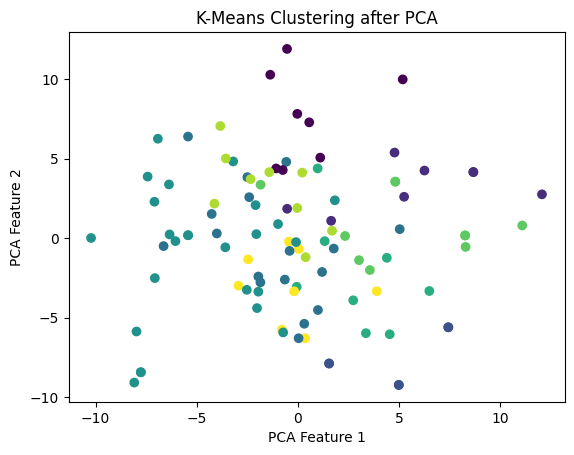

Silhouette Score: 0.06078394129872322


In [ ]:
# CLUSTERING VISUALIZATIONS

import matplotlib.pyplot as plt

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis')
plt.title('K-Means Clustering after PCA')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()

# SILHOUETTE SCORE FOR CLUSTERING ANALYSIS
from sklearn.metrics import silhouette_score

score = silhouette_score(reduced_embeddings, clusters)
print(f'Silhouette Score: {score}')

## (2) DBSCAN Clustering w/UMAP for Dim Reduction

In [ ]:
!pip install sentence-transformers
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
# PRE-PROCESSING

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import zscore

# preprocessing
# df = pd.read_csv('/content/sample_data.csv')
# df = pd.read_csv('/content/sample_data_100.csv')
df = pd.read_csv('/content/sample_data_1000.csv')
# df = pd.read_csv('/content/final_prepped_data.csv')
data = df['Description']
descriptions = []
for i in data:
  i = i.lower()
  descriptions.append(i)
# print(descriptions)

descriptions_to_df = {'Descriptions': descriptions}
df = pd.DataFrame(descriptions_to_df)

In [ ]:
# S-BERT EMBEDDINGS

from sentence_transformers import SentenceTransformer

# Load a pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
embeddings = model.encode(descriptions)
print("Embedding shape:", embeddings.shape)
print("Embedding for the first description:", embeddings[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding shape: (999, 384)
Embedding for the first description: [-5.50343357e-02  8.25789124e-02 -9.16619152e-02  3.25712673e-02
  3.27310488e-02  2.27201991e-02  6.39569387e-02 -9.43176076e-03
 -6.16132133e-02 -1.31685473e-02 -5.55040836e-02 -3.05269193e-02
 -5.35656027e-02  6.64139912e-02  3.52749106e-04 -4.51778807e-03
 -8.91278386e-02 -4.99751046e-02 -1.61261708e-02 -4.75477576e-02
 -4.59061787e-02 -2.06612125e-02 -9.91976820e-03  5.70853055e-02
  4.48192582e-02  6.93757012e-02 -2.33116038e-02  7.99137205e-02
 -4.13844883e-02  2.87000574e-02 -1.41405072e-02  1.19851809e-02
 -1.16849028e-01 -3.32110515e-03  8.91467035e-02 -4.73590493e-02
  2.31604725e-02 -8.47330783e-04  4.22366336e-02  1.77868325e-02
  3.36387157e-02 -6.12180866e-02  1.41376471e-02  5.04031107e-02
 -5.42219542e-02  7.54148513e-02  5.68280406e-02  6.63275421e-02
 -5.90794673e-03 -4.82134521e-02  4.65481281e-02 -3.03051658e-02
  5.82501888e-02 -4.53181826e-02  6.24537142e-03 -2.77440064e-02
  1.45600759e-03 -9.56997

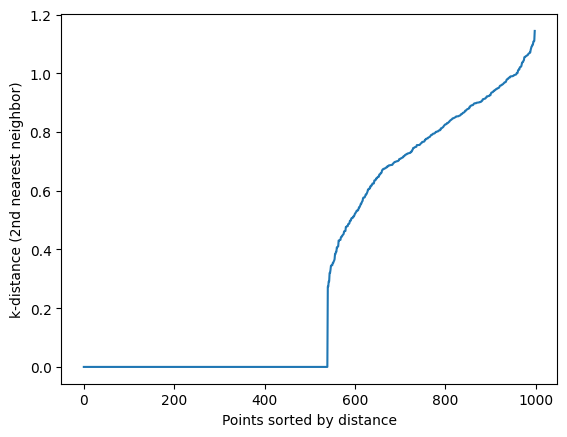

In [ ]:
#k-distance graph to tune eps value for DBSCAN

from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(embeddings)
distances, indices = neighbors_fit.kneighbors(embeddings)

# Sort distance values by ascending value and plot
sorted_distances = np.sort(distances[:, 1], axis=0)
plt.plot(sorted_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (2nd nearest neighbor)')
plt.show()

In [ ]:
# UMAP DIM REDUCTION

from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import pandas as pd

# add noise for spectral initialization
noise = np.random.normal(loc=0.0, scale=0.01, size=embeddings.shape)
noisy_embeddings = embeddings + noise


# Step 3: Dimensionality reduction with UMAP
# umap_model = UMAP(n_neighbors=10, n_components=6, min_dist=0.1, metric='cosine')
umap_model = UMAP(n_neighbors=15, n_components=6, min_dist=0.2, metric='cosine')
embeddings_reduced = umap_model.fit_transform(embeddings)

# Step 4: Clustering with DBSCAN
dbscan = DBSCAN(eps=0.6, min_samples=4)  # cosine
clusters = dbscan.fit_predict(embeddings_reduced)
print(clusters.shape)

# Adding cluster labels to the DataFrame
cluster_df = pd.DataFrame(embeddings_reduced)
cluster_df['Cluster'] = clusters
cluster_df['Description'] = df['Descriptions']
# print(cluster_df['Cluster'])
# print(cluster_df['Description'])

# Step 5: Visualize the clusters
# plt.figure(figsize=(10, 8))
# plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c=clusters, cmap='Spectral', s=5)
# plt.colorbar(ticks=range(len(set(clusters))))
# plt.title('Product Clusters after UMAP and DBSCAN')
# plt.xlabel('UMAP Feature 1')
# plt.ylabel('UMAP Feature 2')
# plt.show()

# SILHOUETTE SCORE FOR CLUSTERING ANALYSIS
from sklearn.metrics import silhouette_score

score = silhouette_score(embeddings_reduced, clusters)
print(f'Silhouette Score: {score}')

(999,)
Silhouette Score: 0.3960072994232178


In [ ]:
# GENERATING KEYWORDS TO CREATE LABELS FOR CLUSTERS

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

unique_labels = set(cluster_df['Cluster'])
keywords_per_cluster = {}

for label in unique_labels:
    if label == -1:
        continue  # skip noise
    # Filter descriptions based on the cluster label
    cluster_descriptions = cluster_df[cluster_df['Cluster'] == label]['Description'].values

    # Set up the CountVectorizer to extract the top 10 words by frequency
    vectorizer = CountVectorizer(stop_words='english', max_features=10)
    X = vectorizer.fit_transform(cluster_descriptions)

    # Sum word occurrences and get feature names
    total_counts = np.sum(X, axis=0)
    terms = vectorizer.get_feature_names_out()

    # Pair terms with their total counts and sort by frequency
    freqs = zip(terms, total_counts.tolist()[0])
    sorted_terms = sorted(freqs, key=lambda x: x[1], reverse=True)

    # Store the top 5 terms for each cluster
    keywords_per_cluster[label] = sorted_terms[:15]

print(keywords_per_cluster)

{0: [('bottle', 33), ('hot', 32), ('water', 32), ('heart', 7), ('babushka', 4), ('chocolate', 4), ('flag', 4), ('grey', 4), ('retrospot', 4), ('union', 4)], 1: [('bag', 39), ('jumbo', 23), ('set', 21), ('vintage', 20), ('red', 18), ('retrospot', 16), ('dolly', 15), ('girl', 15), ('lunch', 15), ('box', 14)], 2: [('red', 22), ('retrospot', 21), ('mug', 15), ('set', 12), ('coffee', 11), ('tea', 10), ('assorted', 8), ('bowl', 8), ('mugs', 7), ('retro', 7)], 3: [('parasol', 8), ('edwardian', 7), ('box', 4), ('boxes', 4), ('pack', 4), ('black', 3), ('24', 2), ('pannetone', 2), ('parasols', 2), ('red', 2)], 4: [('box', 21), ('12', 17), ('kit', 12), ('sewing', 12), ('small', 12), ('tube', 10), ('victorian', 10), ('pack', 9), ('paper', 9), ('woodland', 8)], 5: [('block', 10), ('letters', 7), ('wooden', 6), ('building', 4), ('word', 4), ('noel', 3), ('love', 2), ('bath', 1), ('home', 1), ('joy', 1)], 6: [('light', 27), ('holder', 24), ('hanging', 14), ('heart', 11), ('glass', 9), ('white', 7), (

n_comp = 7, eps=0.6, n_neighbors=15 – 0.302
n_comp = 6, eps=0.6, n_neighbors=10 – 0.359


## Noun Extraction + BERT Embeddings, UMAP + DBSCAN
- extract nouns from the descriptions
- run a cluster algorithm on the nouns

In [ ]:
!pip install nltk

In [ ]:
# PRE-PROCESSING

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import zscore

# preprocessing
# df = pd.read_csv('/content/sample_data.csv')
# df = pd.read_csv('/content/final_prepped_data.csv')
# df = pd.read_csv('/content/sample_data_100.csv')
df = pd.read_csv('/content/sample_data_1000.csv')
data = df['Description']
descriptions = []
for i in data:
  i = i.lower()
  descriptions.append(i)
# print(descriptions)

descriptions_to_df = {'Descriptions': descriptions}
description_df = pd.DataFrame(descriptions_to_df)

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Add custom words to stopwords set (add your specific words here)
custom_stop_words = {'box', 'bag', 'set'}
stop_words.update(custom_stop_words)

def extract_nouns(df):
    noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']  # Tags for singular and plural nouns (common and proper)
    processed_descriptions = []

    for description in df:
        # Tokenize the description
        tokens = word_tokenize(description)
        # Part-of-Speech Tagging
        tagged_tokens = pos_tag(tokens)

        # Filter nouns and check against stop words
        nouns = [word for word, tag in tagged_tokens if tag in noun_tags and word.lower() not in stop_words]

        # Combine nouns back to a string (if needed) or keep as list
        processed_descriptions.append(' '.join(nouns))  # Join as string
        # processed_descriptions.append(nouns)  # Uncomment this to keep as list of nouns

    return processed_descriptions

# Extract nouns
nouns_only_descriptions = extract_nouns(descriptions)
print(nouns_only_descriptions)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['union flag water bottle', 'hand warmer dot', 'ivory cosy', 'colour teaspoons', 'vintage jigsaw blocks', 'love building block word', 'panda bunnies sheet', 'paper chain christmas', 'hand warmer dot', 'heart holder', 'wooden frame', 'coffee mugs', 'metal lantern', 'heart holder', 'pink polkadot', 'pink vintage paisley', 'set/6 paper plates', 'felt egg chicken', 'paper chain christmas', 'toadstool night light', 'glass table pot', 'cake tin cream', 'heart wicker', 'wood', 'jam jars', 'heart doorstop', 'heart hanging decoration', 'hook hanger toadstool', 'alarm clock bakelike green', 'vintage heads tails game', 'heart measuring spoons', 'water bottle', 'plasters tin skulls', 'picnic basket wicker', 'wooden skipping rope', 'star decoration zinc', 'mice feltcraft', 'party cones candy', 'party cones carnival', 'hand warmer owl design', 'heart water bottle', 'font birthday card', 'hand bird design', 'ivory quilt', 'metal lantern', 'picture frame finish', 'glass star holder', 'wooden frame', '

In [ ]:
description_df

,Descriptions
0,knitted union flag hot water bottle
1,hand warmer red polka dot
2,ivory knitted mug cosy
3,box of 6 assorted colour teaspoons
4,box of vintage jigsaw blocks
...,...
94,vanilla scent candle jewelled box
95,12 daisy pegs in wood box
96,lunch bag cars blue
97,set of 3 notebooks in parcel


In [ ]:
print(nouns_only_descriptions)

['union flag water bottle', 'hand warmer dot', 'ivory cosy', 'colour teaspoons', 'vintage jigsaw blocks', 'love building block word', 'panda bunnies sheet', 'paper chain christmas', 'hand warmer dot', 'heart holder', 'wooden frame', 'coffee mugs', 'metal lantern', 'heart holder', 'pink polkadot', 'pink vintage paisley', 'set/6 paper plates', 'felt egg chicken', 'paper chain christmas', 'toadstool night light', 'glass table pot', 'cake tin cream', 'heart wicker', 'wood', 'jam jars', 'heart doorstop', 'heart hanging decoration', 'hook hanger toadstool', 'alarm clock bakelike green', 'vintage heads tails game', 'heart measuring spoons', 'water bottle', 'plasters tin skulls', 'picnic basket wicker', 'wooden skipping rope', 'star decoration zinc', 'mice feltcraft', 'party cones candy', 'party cones carnival', 'hand warmer owl design', 'heart water bottle', 'font birthday card', 'hand bird design', 'ivory quilt', 'metal lantern', 'picture frame finish', 'glass star holder', 'wooden frame', '

In [ ]:
# USING BERT TO EXTRACT WORD EMBEDDINGS

import torch
from transformers import BertModel, BertTokenizer
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Download necessary NLTK resources if not already available
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def extract_noun_embeddings(descriptions):
    noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']  # Tags for nouns
    model.eval()  # Set model to evaluation mode
    embeddings_list = []

    for description in descriptions:
        # Tokenize and POS tag
        tokens = word_tokenize(description)
        tagged_tokens = pos_tag(tokens)

        # Tokenize using BERT tokenizer
        encoded_input = tokenizer(description, return_tensors='pt', padding=True, truncation=True, max_length=512)

        # Extract embeddings with no gradient calculation
        with torch.no_grad():
            output = model(**encoded_input)

        # Consider using the last_hidden_state or pooled output based on your needs
        embeddings = output.last_hidden_state
        embeddings_list.append(embeddings.squeeze().mean(dim=0))  # Average pooling over the sequence dimension

    return embeddings_list

# Extract embeddings with adjectives filtered out
noun_embeddings = extract_noun_embeddings(nouns_only_descriptions)

# Display the size of the first embedding
print("size of first embedding: ", noun_embeddings[0].size())


NameError: name '_C' is not defined

In [ ]:
!pip install sentence-transformers
# !pip install torch

In [ ]:
# S-BERT EMBEDDINGS

# import torch
# import transformers
from sentence_transformers import SentenceTransformer

# Load a pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
embeddings = model.encode(nouns_only_descriptions)
print("Embedding shape:", embeddings.shape)
print("Embedding for the first description:", embeddings[0])

# # Standardize embeddings
# scaler = StandardScaler()
# embeddings_standardized = scaler.fit_transform(embeddings)
# #print("Embeddings have been standardized")

NameError: name '_C' is not defined

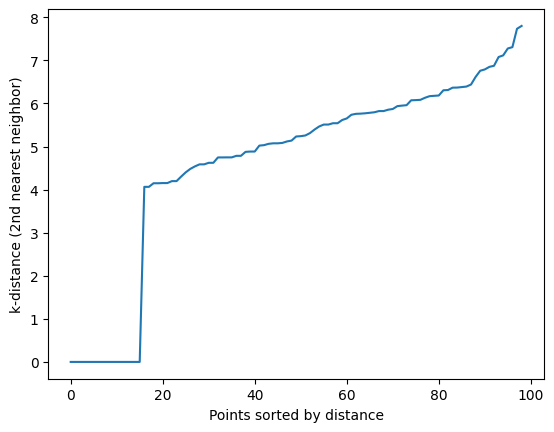

In [ ]:
#k-distance graph to tune eps value for DBSCAN

from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(noun_embeddings)
distances, indices = neighbors_fit.kneighbors(noun_embeddings)

# Sort distance values by ascending value and plot
sorted_distances = np.sort(distances[:, 1], axis=0)
plt.plot(sorted_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (2nd nearest neighbor)')
plt.show()

In [ ]:
# UMAP DIM REDUCTION

from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import pandas as pd

# # add noise for spectral initialization
# noise = np.random.normal(loc=0.0, scale=0.01, size=noun_embeddings.shape)
# noisy_embeddings = noun_embeddings + noise

# Step 3: Dimensionality reduction with UMAP
# umap_model = UMAP(n_neighbors=10, n_components=6, min_dist=0.1, metric='cosine')
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.1, metric='cosine')
embeddings_reduced = umap_model.fit_transform(noun_embeddings)
print(embeddings_reduced.shape)

# Step 4: Clustering with DBSCAN
# dbscan = DBSCAN(eps=0.6, min_samples=4)  # cosine
dbscan = DBSCAN(eps=0.5, min_samples=4)  # cosine
clusters = dbscan.fit_predict(embeddings_reduced)

# Adding cluster labels to the DataFrame
cluster_df = pd.DataFrame(embeddings_reduced)
cluster_df['Cluster'] = clusters
cluster_df['Description'] = description_df['Descriptions']
# print(cluster_df['Cluster'])
# print(cluster_df['Description'])

# SILHOUETTE SCORE FOR CLUSTERING ANALYSIS
from sklearn.metrics import silhouette_score

score = silhouette_score(embeddings_reduced, clusters)
print(f'Silhouette Score: {score}')

(99, 5)
Silhouette Score: 0.3437036871910095


In [ ]:
# GENERATING KEYWORDS TO CREATE LABELS FOR CLUSTERS

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

unique_labels = set(cluster_df['Cluster'])
keywords_per_cluster = {}

for label in unique_labels:
    if label == -1:
        continue  # skip noise
    # Filter descriptions based on the cluster label
    cluster_descriptions = cluster_df[cluster_df['Cluster'] == label]['Description'].values

    # Set up the CountVectorizer to extract the top 10 words by frequency
    vectorizer = CountVectorizer(stop_words='english', max_features=10)
    X = vectorizer.fit_transform(cluster_descriptions)

    # Sum word occurrences and get feature names
    total_counts = np.sum(X, axis=0)
    terms = vectorizer.get_feature_names_out()

    # Pair terms with their total counts and sort by frequency
    freqs = zip(terms, total_counts.tolist()[0])
    sorted_terms = sorted(freqs, key=lambda x: x[1], reverse=True)

    # Store the top 5 terms for each cluster
    keywords_per_cluster[label] = sorted_terms[:15]

print(keywords_per_cluster)

{0: [('flag', 3), ('union', 3), ('bottle', 2), ('hot', 2), ('knitted', 2), ('water', 2), ('jack', 1), ('luggage', 1), ('tag', 1)], 1: [('dot', 2), ('hand', 2), ('polka', 2), ('red', 2), ('warmer', 2), ('box', 1), ('lavender', 1), ('mug', 1), ('scent', 1), ('tin', 1)], 2: [('assorted', 3), ('cones', 2), ('party', 2), ('box', 1), ('cake', 1), ('candy', 1), ('carnival', 1), ('colour', 1), ('cream', 1), ('green', 1)], 3: [('blocks', 1), ('box', 1), ('calculator', 1), ('chocolate', 1), ('heart', 1), ('jigsaw', 1), ('large', 1), ('measuring', 1), ('spoons', 1), ('vintage', 1)], 4: [('block', 2), ('building', 2), ('love', 2), ('word', 2), ('billboard', 1), ('bobbles', 1), ('cover', 1), ('fly', 1), ('hate', 1), ('home', 1)], 5: [('50', 2), ('chain', 2), ('christmas', 2), ('kit', 2), ('paper', 2), ('bunnies', 1), ('holiday', 1), ('metal', 1), ('panda', 1), ('sheet', 1)], 6: [('heart', 3), ('hanging', 2), ('holder', 2), ('light', 2), ('white', 2), ('doorstop', 1), ('gingham', 1), ('red', 1)], 7:

## refined pre-processing, S-BERT Embeddings, UMAP + DBSCAN



In [ ]:
!pip install sentence-transformers
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
# PRE-PROCESSING

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import zscore

# preprocessing
# df = pd.read_csv('/content/sample_data.csv')
# df = pd.read_csv('/content/sample_data_100.csv')
# df = pd.read_csv('/content/sample_data_1000.csv')
og_df = pd.read_csv('/content/final_prepped_data.csv')
data = og_df['Description']
descriptions = []
for i in data:
  i = i.lower()
  descriptions.append(i)

descriptions = list(set(descriptions))
# print(len(unique_descriptions))

descriptions_to_df = {'Descriptions': descriptions}
df = pd.DataFrame(descriptions_to_df)
df = df.drop_duplicates()
print(df.shape)

(3645, 1)


In [ ]:
# S-BERT EMBEDDINGS

from sentence_transformers import SentenceTransformer

# Load a pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
embeddings = model.encode(descriptions)
print("Embedding shape:", embeddings.shape)
print("Embedding for the first description:", embeddings[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding shape: (3645, 384)
Embedding for the first description: [-3.70761901e-02  2.93445662e-02  1.54572772e-02  1.92398764e-02
  1.46393301e-02  6.62586167e-02  7.46553093e-02 -3.25705740e-03
 -4.11818223e-03  4.19464521e-02 -5.59864230e-02 -6.32011443e-02
 -5.19854240e-02  8.39413851e-02 -6.26609102e-02 -8.41871500e-02
 -1.08070500e-01 -1.32480925e-02  7.43156718e-03 -2.53209788e-02
 -9.65195242e-04 -2.24794112e-02  5.42074032e-02  8.66149494e-04
  8.81023929e-02  6.75787926e-02  4.04047780e-03  3.56862694e-02
  3.45153511e-02  4.48709503e-02  2.17732973e-02 -7.14145927e-03
 -1.43165618e-01 -1.06770070e-02 -7.46193603e-02 -4.44124751e-02
  6.08296283e-02  4.78410870e-02  7.19569251e-02 -3.54273207e-02
  3.24288644e-02 -3.02692018e-02  9.40542761e-03  1.38780214e-02
  4.57558286e-04  5.18966392e-02  2.89010629e-02  4.76981653e-03
 -4.34326800e-03 -5.49848527e-02  1.48308342e-02  5.67992777e-03
  1.41176153e-02  1.14876609e-02  1.94197372e-02 -2.95039807e-02
  7.07307383e-02  1.1156

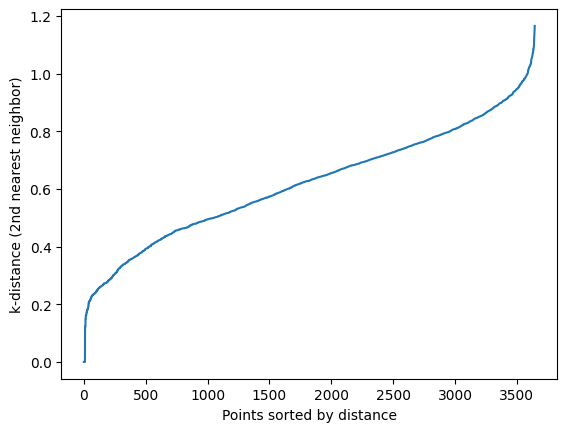

In [ ]:
#k-distance graph to tune eps value for DBSCAN

from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(embeddings)
distances, indices = neighbors_fit.kneighbors(embeddings)

# Sort distance values by ascending value and plot
sorted_distances = np.sort(distances[:, 1], axis=0)
plt.plot(sorted_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (2nd nearest neighbor)')
plt.show()

In [ ]:
# UMAP DIM REDUCTION

from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import pandas as pd

# # add noise for spectral initialization
# noise = np.random.normal(loc=0.0, scale=0.01, size=embeddings.shape)
# embeddings = embeddings + noise

# Dimensionality reduction with UMAP
umap_model = UMAP(n_neighbors=10, n_components=6, min_dist=0.1, metric='cosine')
embeddings_reduced = umap_model.fit_transform(embeddings)

# Clustering with DBSCAN
# dbscan = DBSCAN(eps=0.4, min_samples=4)  # cosine, 1000 pts, nouns not extracted
dbscan = DBSCAN(eps=0.25, min_samples=4)  # cosine, 3.5k pts, 0.41, nouns not extracted
# dbscan = DBSCAN(eps=0.4, min_samples=4)  # cosine, 3.5k pts, 0.31, nouns extracted
clusters = dbscan.fit_predict(embeddings_reduced)

# Adding cluster labels to the DataFrame
cluster_df = pd.DataFrame(embeddings_reduced)
cluster_df['Cluster'] = clusters
cluster_df['Description'] = df['Descriptions']
# print(cluster_df['Cluster'])
# print(cluster_df['Description'])

# Visualize the clusters
# plt.figure(figsize=(10, 8))
# plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c=clusters, cmap='Spectral', s=5)
# plt.colorbar(ticks=range(len(set(clusters))))
# plt.title('Product Clusters after UMAP and DBSCAN')
# plt.xlabel('UMAP Feature 1')
# plt.ylabel('UMAP Feature 2')
# plt.show()

# SILHOUETTE SCORE FOR CLUSTERING ANALYSIS
from sklearn.metrics import silhouette_score

score = silhouette_score(embeddings_reduced, clusters)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.4154292643070221


In [ ]:
# CENTROID ANALYSIS

import numpy as np
from scipy.spatial import distance

embeddings = np.array(embeddings_reduced)
labels = np.array(clusters)
descriptions_array = np.array(df)
closest_words = {}

# Calculate the centroid of each cluster
def compute_centroids(embeddings, labels):
    unique_labels = set(labels)
    centroids = []
    for label in unique_labels:
        if label != -1:  # Exclude noise points which are labeled as -1
            # Select all embeddings with the current cluster label
            cluster_embeddings = embeddings[labels == label]
            # Calculate the centroid of these embeddings
            centroid = np.mean(cluster_embeddings, axis=0)
            centroids.append((label, centroid))
    return centroids

# Function to find the closest words to each centroid
def closest_embeddings_to_centroids(centroids, embeddings, num_closest=5):
    closest = {}
    for label, centroid in centroids:
        # Calculate distances from centroid to all embeddings
        dists = distance.cdist([centroid], embeddings, 'cosine')[0]
        # Get indices of embeddings with smallest distances
        closest_indices = np.argsort(dists)[:num_closest]
        closest[label] = closest_indices
        # Map indices to words
        closest_words[label] = [descriptions_array[idx] for idx in closest_indices]
    return closest_words
    # return closest

# Example usage
centroids = compute_centroids(embeddings, labels)
closest_indices = closest_embeddings_to_centroids(centroids, embeddings)

# Printing closest embeddings' indices for each cluster

# print("Closest embeddings to centroids:")
# for label, indices in closest_indices.items():
    # print(f"Cluster {label}: Indices {indices}")
    # print(f"Cluster {label}: {indices}")

Closest embeddings to centroids:
Cluster 0: [array(['retro coffee mugs assorted'], dtype=object), array(['queens guard coffee mug'], dtype=object), array(['hardman mug 3 assorted'], dtype=object), array(['london bus coffee mug'], dtype=object), array(['small white retrospot mug in box'], dtype=object)]
Cluster 1: [array(["thrown away-can't sell."], dtype=object), array(['manual'], dtype=object), array(['test'], dtype=object), array(['check'], dtype=object), array(['counted'], dtype=object)]
Cluster 2: [array(['blue drawer knob acrylic edwardian'], dtype=object), array(['red drawer knob acrylic edwardian'], dtype=object), array(['green drawer knob acrylic edwardian'], dtype=object), array(['pink drawer knob acrylic edwardian'], dtype=object), array(['clear drawer knob acrylic edwardian'], dtype=object)]
Cluster 3: [array(['balloon water bomb pack of 35'], dtype=object), array(['6 rocket balloons'], dtype=object), array(['balloon pump with 10 balloons'], dtype=object), array(['12 coloure

In [ ]:
# GENERATING KEYWORDS PER CLUSTER

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

unique_labels = set(cluster_df['Cluster'])
keywords_per_cluster = {}

for label in unique_labels:
    if label == -1:
        continue  # skip noise
    # Filter descriptions based on the cluster label
    cluster_descriptions = cluster_df[cluster_df['Cluster'] == label]['Description'].values

    # Set up the CountVectorizer to extract the top 10 words by frequency
    vectorizer = CountVectorizer(stop_words='english', max_features=10)
    X = vectorizer.fit_transform(cluster_descriptions)

    # Sum word occurrences and get feature names
    total_counts = np.sum(X, axis=0)
    terms = vectorizer.get_feature_names_out()

    # Pair terms with their total counts and sort by frequency
    freqs = zip(terms, total_counts.tolist()[0])
    sorted_terms = sorted(freqs, key=lambda x: x[1], reverse=True)

    # Store the top 5 terms for each cluster
    keywords_per_cluster[label] = sorted_terms[:5]

print(keywords_per_cluster)

{0: [('mug', 41), ('coffee', 14), ('design', 11), ('vintage', 9), ('box', 7)], 1: [('dotcom', 8), ('sold', 6), ('wet', 6), ('amazon', 4), ('missing', 4)], 2: [('drawer', 8), ('knob', 8), ('acrylic', 6), ('edwardian', 6), ('glass', 3)], 3: [('set', 8), ('balloons', 6), ('badges', 5), ('balloon', 3), ('skull', 2)], 4: [('herb', 6), ('marker', 6), ('basil', 1), ('chives', 1), ('mint', 1)], 5: [('key', 23), ('ring', 23), ('bling', 22), ('letter', 22), ('assorted', 1)], 6: [('bag', 66), ('jumbo', 19), ('vintage', 17), ('lunch', 12), ('red', 12)], 7: [('incense', 22), ('origami', 9), ('set', 6), ('candle', 4), ('tin', 4)], 8: [('light', 70), ('holder', 66), ('hanging', 19), ('heart', 16), ('glass', 15)], 9: [('rose', 5), ('du', 4), ('sud', 4), ('bag', 2), ('clothes', 1)], 10: [('christmas', 51), ('heart', 49), ('decoration', 44), ('tree', 31), ('garland', 27)], 11: [('spaceboy', 13), ('space', 6), ('childrens', 5), ('cadet', 3), ('cup', 3)], 12: [('wrap', 41), ('images', 12), ('gift', 11), (

run cluster keywords + centroid analysis :through an LLM to consolidate all products into the minimal number of product categories necessary:

1. Home and Garden Essentials:
- Garden accessories (Clusters 0, 3, 10, 23, 25, 35, 38, 43, 48, 60, 107, 141, 142, 156, 181, 182, 185, 187, 192, 200, 203)
- Home decor (Clusters 9, 13, 14, 20, 29, 44, 77, 82, 83, 85, 86, 99, 100, 123, 127, 139, 145, 149, 158, 159, 160, 161, 162, 165, 168, 169, 173, 174, 175, 176, 188, 189, 190, 199)
2. Fashion and Jewelry:
- Accessories like bags and purses (Clusters 5, 16, 31, 49, 61, 88, 91, 93, 109, 144)
- Jewelry and watches (Clusters 2, 4, 65, 63, 72, 105, 166, 191)
3. Crafts and Hobbies:
- Sewing and knitting kits (Clusters 8, 36, 47, 113, 114, 138)
- DIY and craft supplies (Clusters 8, 41, 52, 57, 66, 106, 116, 117, 118, 138, 146, 147, 150, 153, 163, 164, 183, 184, 198)
4. Kitchen and Dining:
- Tableware and kitchen utensils (Clusters 1, 21, 22, 26, 27, 28, 33, 42, 46, 47, 53, 54, 78, 79, 92, 104, 121, 131, 141, 188)
5. Gifts and Seasonal:
- Festive and seasonal decorations (Clusters 67, 68, 70, 71, 74, 75, 84, 89, 90, 120, 128, 170, 171, 179, 180)
- Gifts and novelty items (Clusters 6, 30, 32, 50, 51, 59, 102, 103, 112, 115, 122, 126, 133, 135, 137, 144, 150, 151, 155, 157, 167, 190, 193, 194, 195, 202, 204, 205)
6. Bath and Beauty:
- Toiletries and beauty products (Clusters 18, 62, 64, 81, 87, 97, 98, 111, 123, 125, 132, 152, 154, 165, 186, 197)
7. Children's Products:
- Children's toys and games (Clusters 11, 38, 39, 54, 61, 65, 66, 89, 102, 109, 130, 156, 157, 158, 167, 170, 200)
8. Stationery and Office:
- Stationery and office supplies (Clusters 15, 34, 40, 55, 56, 58, 96, 103, 106, 112, 113, 115, 138, 139, 144, 146, 150, 196)



In [ ]:
# MAP EVERY CLUSTER TO A CATEGORY

from collections import defaultdict

# keywords_per_cluster

category_clusters = {
    'Garden Accessories': [0, 3, 10, 23, 25, 35, 38, 43, 48, 60, 107, 141, 142, 156, 181, 182, 185, 187, 192, 200, 203],
    'Home Decor' : [9, 13, 14, 20, 29, 44, 77, 82, 83, 85, 86, 99, 100, 123, 127, 139, 145, 149, 158, 159, 160, 161, 162, 165, 168, 169, 173, 174, 175, 176, 188, 189, 190, 199],
    'Accessories' : [],
    'Bags and Purses': [5, 16, 31, 49, 61, 88, 91, 93, 109, 144],
    'Jewelry and Watches' : [2, 4, 65, 63, 72, 105, 166, 191],
    'Sewing and Knitting Kits': [8, 36, 47, 113, 114, 138],
    'DIY and Craft Supplies': [8, 41, 52, 57, 66, 106, 116, 117, 118, 138, 146, 147, 150, 153, 163, 164, 183, 184, 198, 8, 36, 47, 113, 114, 138],
    'Kitchen and Dining': [1, 21, 22, 26, 27, 28, 33, 42, 46, 47, 53, 54, 78, 79, 92, 104, 121, 131, 141, 188],
    'Festive and Seasonal Decorations': [67, 68, 70, 71, 74, 75, 84, 89, 90, 120, 128, 170, 171, 179, 180],
    'Gifts and Novelty Items': [6, 30, 32, 50, 51, 59, 102, 103, 112, 115, 122, 126, 133, 135, 137, 144, 150, 151, 155, 157, 167, 190, 193, 194, 195, 202, 204, 205],
    'Bath and Beauty': [18, 62, 64, 81, 87, 97, 98, 111, 123, 125, 132, 152, 154, 165, 186, 197],
    'Toys and Games': [11, 38, 39, 54, 61, 65, 66, 89, 102, 109, 130, 156, 157, 158, 167, 170, 200],
    'Stationary and Office': [15, 34, 40, 55, 56, 58, 96, 103, 106, 112, 113, 115, 138, 139, 144, 146, 150, 196]
}

def map_categories_to_keywords(category_clusters, keywords_per_cluster):
    category_keywords = {}

    for category, clusters in category_clusters.items():
        # Initialize a set to hold unique keywords for this category
        category_keywords[category] = set()

        for cluster in clusters:
            # Add keywords from this cluster to the category's set
            category_keywords[category].update(keywords_per_cluster.get(cluster, []))

    # Convert the sets to lists for easier readability
    category_keywords = {cat: list(keywords) for cat, keywords in category_keywords.items()}

    return category_keywords

def assign_clusters_to_categories(category_keywords, keywords_per_cluster):
    # Create a dictionary to hold the categories and their list of clusters
    category_clusters_mapping = {}

    # Flatten the category keywords into a set for easier searching
    flat_category_keywords = {
        category: set([kw for item in kws for kw in (item if isinstance(item, tuple) else (item,))])
        for category, kws in category_keywords.items()
    }

    # Iterate over each cluster and its keywords
    for cluster, keyword_tuples in keywords_per_cluster.items():
        # Convert list of keyword tuples to a set of keywords, disregarding the numbers
        cluster_keywords = set([kw for kw, _ in keyword_tuples])

        # Initialize a dictionary to count category matches for this cluster
        category_match_count = {category: 0 for category in category_keywords}

        # Iterate through each category to see if there's a match with the cluster keywords
        for category, cat_keywords in flat_category_keywords.items():
            # Count the number of matches between cluster keywords and category keywords
            match_count = len(cluster_keywords.intersection(cat_keywords))
            category_match_count[category] = match_count

        # Find the category with the highest number of matches
        best_category = max(category_match_count, key=category_match_count.get)

        # If there are no matches, you may decide to label it as 'Miscellaneous' or similar
        if category_match_count[best_category] == 0:
            best_category = 'Miscellaneous'

        # Assign the cluster to the best matching category
        if best_category not in category_clusters_mapping:
            category_clusters_mapping[best_category] = []
        category_clusters_mapping[best_category].append(cluster)

    return category_clusters_mapping

def simplify_keywords(cluster_to_category):
    simplified = {}
    for category, keywords in cluster_to_category.items():
        simplified_keywords = []
        for item in keywords:
            # Check if the item is a tuple and unpack accordingly
            if isinstance(item, tuple):
                keyword, _ = item
                simplified_keywords.append(keyword)
            else:
                # If the item is not a tuple, handle it as a raw keyword
                print(item)
                # simplified_keywords.append(item)
        simplified[category] = simplified_keywords
    return simplified


# Generate the dictionary mapping categories to keywords
print(keywords_per_cluster)
category_to_keywords_dict = map_categories_to_keywords(category_clusters, keywords_per_cluster)
print(category_to_keywords_dict)

# # Map clusters to categories
cluster_to_category = assign_clusters_to_categories(category_to_keywords_dict, keywords_per_cluster)
print(cluster_to_category)

# Simplify cluster_to_category
simplified_cluster_to_category = simplify_keywords(category_to_keywords_dict)
print(simplified_cluster_to_category)

{0: [('mug', 41), ('coffee', 14), ('design', 11), ('vintage', 9), ('box', 7)], 1: [('dotcom', 8), ('sold', 6), ('wet', 6), ('amazon', 4), ('missing', 4)], 2: [('drawer', 8), ('knob', 8), ('acrylic', 6), ('edwardian', 6), ('glass', 3)], 3: [('set', 8), ('balloons', 6), ('badges', 5), ('balloon', 3), ('skull', 2)], 4: [('herb', 6), ('marker', 6), ('basil', 1), ('chives', 1), ('mint', 1)], 5: [('key', 23), ('ring', 23), ('bling', 22), ('letter', 22), ('assorted', 1)], 6: [('bag', 66), ('jumbo', 19), ('vintage', 17), ('lunch', 12), ('red', 12)], 7: [('incense', 22), ('origami', 9), ('set', 6), ('candle', 4), ('tin', 4)], 8: [('light', 70), ('holder', 66), ('hanging', 19), ('heart', 16), ('glass', 15)], 9: [('rose', 5), ('du', 4), ('sud', 4), ('bag', 2), ('clothes', 1)], 10: [('christmas', 51), ('heart', 49), ('decoration', 44), ('tree', 31), ('garland', 27)], 11: [('spaceboy', 13), ('space', 6), ('childrens', 5), ('cadet', 3), ('cup', 3)], 12: [('wrap', 41), ('images', 12), ('gift', 11), (

In [ ]:
# AMENDING DATAFRAME W/CATEGORIES, SUBCATEGORIES


# amended category_mappings (to include all clusters possible, minimize 'miscellaneous') = cluster_to_category
# categories mapped to keywords = simplified_cluster_to_category

subcategory_mappings = {
    'Garden Accessories': [0, 3, 10, 23, 25, 35, 38, 43, 48, 60, 107, 141, 142, 156, 181, 182, 185, 187, 192, 200, 203],
    'Home Decor' : [9, 13, 14, 20, 29, 44, 77, 82, 83, 85, 86, 99, 100, 123, 127, 139, 145, 149, 158, 159, 160, 161, 162, 165, 168, 169, 173, 174, 175, 176, 188, 189, 190, 199],
    'Bags and Purses': [5, 16, 31, 49, 61, 88, 91, 93, 109, 144],
    'Jewelry and Watches' : [2, 4, 65, 63, 72, 105, 166, 191],
    'Sewing and Knitting Kits': [8, 36, 47, 113, 114, 138],
    'DIY and Craft Supplies': [8, 41, 52, 57, 66, 106, 116, 117, 118, 138, 146, 147, 150, 153, 163, 164, 183, 184, 198],
    'Kitchen and Dining': [1, 21, 22, 26, 27, 28, 33, 42, 46, 47, 53, 54, 78, 79, 92, 104, 121, 131, 141, 188],
    'Festive and Seasonal Decorations': [67, 68, 70, 71, 74, 75, 84, 89, 90, 120, 128, 170, 171, 179, 180],
    'Gifts and Novelty Items': [6, 30, 32, 50, 51, 59, 102, 103, 112, 115, 122, 126, 133, 135, 137, 144, 150, 151, 155, 157, 167, 190, 193, 194, 195, 202, 204, 205],
    'Bath and Beauty': [18, 62, 64, 81, 87, 97, 98, 111, 123, 125, 132, 152, 154, 165, 186, 197],
    'Toys and Games': [11, 38, 39, 54, 61, 65, 66, 89, 102, 109, 130, 156, 157, 158, 167, 170, 200],
    'Stationary and Office': [15, 34, 40, 55, 56, 58, 96, 103, 106, 112, 113, 115, 138, 139, 144, 146, 150, 196]
}


# Function to map clusters to categories and subcategories
def map_category_and_subcategory(row, category_mapppings, subcategory_mappings):
    for category, clusters in category_mappings.items():
        if row['Cluster'] in clusters:
            row['Category'] = category
            break
        else:
            row['Category'] = 'Miscellaneous'

    for subcategory, clusters in subcategory_mappings.items():
        if row['Cluster'] in clusters:
            row['Subcategory'] = subcategory
            break
        else:
            row['Subcategory'] = 'Miscellaneous'

    return row

# Apply the mapping function to each row in DataFrame
cluster_df = cluster_df.apply(map_category_and_subcategory, axis=1, args=(simplified_cluster_to_category, subcategory_mappings))

# Check the DataFrame with new columns
print(cluster_df[['Description', 'Category', 'Subcategory']])

# Standardize the 'Description' by stripping leading/trailing spaces and converting to lower case
og_df['Description'] = og_df['Description'].str.strip().str.lower()
cluster_df['Description'] = cluster_df['Description'].str.strip().str.lower()

# Merge operation
result_df = pd.merge(og_df, cluster_df[['Description', 'Category', 'Subcategory']], on='Description', how='left')

print(result_df.head())

                          Description                    Category  \
0                potting shed tea mug  Home and Garden Essentials   
1                             missing          Kitchen and Dining   
2      drawer knob vintage glass star         Fashion and Jewelry   
3        3d dog picture playing cards  Home and Garden Essentials   
4           set/4 badges balloon girl  Home and Garden Essentials   
...                               ...                         ...   
3640  decoration hen on nest, hanging  Home and Garden Essentials   
3641           feather pen,coal black          Crafts and Hobbies   
3642           felt egg cosy ladybird  Home and Garden Essentials   
3643      doorknob cracked glaze blue  Home and Garden Essentials   
3644           party food shopper bag          Gifts and Seasonal   

                  Subcategory  
0          Garden Accessories  
1          Kitchen and Dining  
2         Jewelry and Watches  
3                  Home Decor  
4          

In [ ]:
result_df.to_csv('post_nlp_data.csv')